In [1]:
from load_data import load_json_data

# Load data
data = load_json_data("data/result.json", 1000, 1520)
data[-1]

[{'filename': '03577_0',
  'sentence1': 'a big blue building has been built in the middle of the scene ',
  'sentence2': 'the bareland has been replaced by a blue building and a big blue building has been built ',
  'sentence3': 'two big blue buildings have been replaced by a blue building '},
 {'filename': '03577_1',
  'sentence1': 'a small blue building has been constructed on the bareland at the corner of the scene ',
  'sentence2': 'many trees have appeared in many parts of the scene ',
  'sentence3': 'many green trees have been constructed on the bareland and the grassland '},
 {'filename': '03577_2',
  'sentence1': 'a big building has been constructed in many parts of the scene ',
  'sentence2': 'a blue building has been constructed in the green area ',
  'sentence3': 'a big building has been constructed in the green area '},
 {'filename': '03577_3',
  'sentence1': 'two blue buildings have been built in many parts of the scene ',
  'sentence2': 'two blue buildings have been built

In [3]:
# Path: RL_policy.ipynb
from load_data import load_extracted_features
features = load_extracted_features("02243")
features

[array([-2.852418  , -0.3598552 , -0.64396954, ..., -3.7601597 ,
        -2.4142437 , -0.73389924], dtype=float32),
 array([-3.5670743 , -2.616459  , -2.4648798 , ..., -4.367136  ,
        -0.19193462, -1.1204567 ], dtype=float32),
 array([-2.0376918,  2.6945443, -2.5628326, ..., -1.4267876,  1.356801 ,
         1.0070316], dtype=float32),
 array([ 1.61934   ,  0.7839722 , -1.4668478 , ...,  2.6288903 ,
         0.19116966, -1.5600281 ], dtype=float32),
 array([ 1.8105732 ,  1.0538902 ,  1.255107  , ...,  1.9745277 ,
        -0.94601136, -4.8783593 ], dtype=float32),
 array([-1.4364594 , -0.7220393 ,  0.83130527, ..., -2.8415883 ,
         1.8530447 , -1.3842025 ], dtype=float32),
 array([-1.325945  ,  1.6192777 , -0.28317976, ...,  0.35340035,
        -0.7117377 , -1.4554265 ], dtype=float32),
 array([ 3.4042222 ,  3.2917116 , -0.21354564, ...,  1.0218418 ,
        -0.2932795 ,  0.01013771], dtype=float32),
 array([ 1.9444352 ,  2.3477812 ,  0.16965462, ...,  8.649478  ,
         2.09

#### Prepare Training data

In [4]:
from load_data import load_extracted_features

training_data = []

for item_group in data:
    for index, item in enumerate(item_group):
        if "slider1" not in item:
            continue
        file_name = item['filename'].split("_")[0]
        features = load_extracted_features(file_name)
        
        # Her bir item için features listesini dörde böl ve ilgili parçayı kullan
        item_features = []
        for i in range(4):
            item_features.append(features[index * 4 + i])

        training_data.append({
            "features": item_features,
            "sentences": [item["sentence1"], item["sentence2"], item["sentence3"]],
            "slider_values": [item["slider1"], item["slider2"], item["slider3"]]
        })

training_data[-1]

{'features': [array([-3.895567  , -0.7710196 , -1.379711  , ..., -4.317973  ,
         -0.24954835, -0.5057722 ], dtype=float32),
  array([ 0.29719004, -2.1620078 , -4.0901904 , ..., -1.0636894 ,
         -0.65524375,  2.9486067 ], dtype=float32),
  array([-4.715664 , -2.0460691, -1.6050384, ..., -6.1682596, -1.5817506,
         -1.0122457], dtype=float32),
  array([-0.8934293,  1.7406154,  2.1094537, ..., -6.358255 , -2.441966 ,
          3.5570562], dtype=float32)],
 'sentences': ['two buildings have been constructed on the bareland in the middle of the scene ',
  'a huge building has been constructed on the green area at the corner of the scene ',
  'two buildings have been constructed on the green area in the middle '],
 'slider_values': [4, 2, 3]}

#### Split The Data

In [5]:
# Split data into train and test
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(training_data, test_size=0.2, random_state=42)

#### Q-Learning Class
* Define Q-Learning Class

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Dropout katmanı
        self.fc2 = nn.Linear(128, 64)  # Ekstra bir gizli katman
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)  # İkinci bir dropout katmanı
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

class QLearningModel:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995, use_gpu=False):
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

        self.model = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.randint(0, self.action_size - 1)
        else:
            state = torch.tensor([state], dtype=torch.float32).to(self.device)
            q_values = self.model(state)
            _, action = torch.max(q_values, 1)
            return action.item()
        
    def decay_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(0.01, self.exploration_rate)

    def update(self, state, action, reward, next_state):
        state = torch.tensor([state], dtype=torch.float32).to(self.device)
        next_state = torch.tensor([next_state], dtype=torch.float32).to(self.device)
        reward = torch.tensor(reward, dtype=torch.float32).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)

        current_q = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)
        max_next_q = self.model(next_state).max(1)[0]
        expected_q = reward + self.discount_factor * max_next_q

        loss = self.criterion(current_q, expected_q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))

#### Early Stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, average_reward):
        score = average_reward

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

#### Preprocess The Data
* Using BERT Model We've to encode the sentences for Deep Q Learning Layer

In [ ]:
import numpy as np
import torch
import tqdm
from transformers import BertTokenizer, BertModel

def bert_encode(sentences, bert_model, tokenizer, device, batch_size=32):
    bert_model.to(device)
    bert_model.eval()  # Modeli değerlendirme modunda çalıştır

    # Tüm cümleleri batch'ler halinde işle
    all_sentence_embeddings = []
    for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="BERT Encoding"):
        batch_sentences = sentences[i:i+batch_size]
        encoded = tokenizer.batch_encode_plus(
            batch_sentences,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            sentence_embeddings = outputs[0][:, 0, :]  # [CLS] token'ın çıktısını al
            all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

    return np.array(all_sentence_embeddings)

def collect_all_sentences(data):
    all_sentences = []
    sentence_lengths = []
    for data_point in data:
        sentences = data_point['sentences']
        all_sentences.extend(sentences)
        sentence_lengths.append(len(sentences))
    return all_sentences, sentence_lengths

def distribute_embeddings_to_data_points(all_embeddings, data, sentence_lengths):
    bert_encoded_data = []
    start_index = 0
    for data_point, length in zip(data, sentence_lengths):
        encoded_sentences = all_embeddings[start_index:start_index + length]
        encoded_sentences_array = np.array(encoded_sentences)
        bert_encoded_data.append((data_point, encoded_sentences_array))
        start_index += length
    return bert_encoded_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
batch_size = 128

# Tüm cümleleri topla ve BERT kodlamalarını hesapla
all_train_sentences, train_sentence_lengths = collect_all_sentences(train_data)
all_train_embeddings = bert_encode(all_train_sentences, bert_model, tokenizer, device, batch_size)

# Kodlamaları ilgili eğitim veri noktalarına dağıt
train_data_with_bert = distribute_embeddings_to_data_points(all_train_embeddings, train_data, train_sentence_lengths)

# Test verisi için de aynı işlemi yap
all_test_sentences, test_sentence_lengths = collect_all_sentences(test_data)
all_test_embeddings = bert_encode(all_test_sentences, bert_model, tokenizer, device, batch_size)
test_data_with_bert = distribute_embeddings_to_data_points(all_test_embeddings, test_data, test_sentence_lengths)

#free gpu memory
if torch.cuda.is_available():
    torch.cuda.empty_cache()


#### Train The Model

Training:  96%|█████████▌| 478/500 [00:44<00:01, 11.02it/s]

Epoch 476: Train Avg Reward = -1.0655368926214757, Test Avg Reward = -0.9136690647482014
Epoch 477: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309
Epoch 478: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309


Training:  96%|█████████▋| 482/500 [00:44<00:01, 11.11it/s]

Epoch 479: Train Avg Reward = -1.0955308938212358, Test Avg Reward = -0.959832134292566
Epoch 480: Train Avg Reward = -1.207258548290342, Test Avg Reward = -1.0719424460431655
Epoch 481: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309


Training:  97%|█████████▋| 484/500 [00:44<00:01, 11.36it/s]

Epoch 482: Train Avg Reward = -1.0955308938212358, Test Avg Reward = -0.959832134292566
Epoch 483: Train Avg Reward = -1.0655368926214757, Test Avg Reward = -0.9136690647482014
Epoch 484: Train Avg Reward = -1.0655368926214757, Test Avg Reward = -0.9136690647482014


Training:  98%|█████████▊| 488/500 [00:45<00:01, 10.97it/s]

Epoch 485: Train Avg Reward = -0.9838032393521295, Test Avg Reward = -0.8477218225419664
Epoch 486: Train Avg Reward = -1.207258548290342, Test Avg Reward = -1.0719424460431655
Epoch 487: Train Avg Reward = -0.9838032393521295, Test Avg Reward = -0.8477218225419664


Training:  98%|█████████▊| 490/500 [00:45<00:00, 11.21it/s]

Epoch 488: Train Avg Reward = -1.0655368926214757, Test Avg Reward = -0.9136690647482014
Epoch 489: Train Avg Reward = -1.207258548290342, Test Avg Reward = -1.0719424460431655
Epoch 490: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309


Training:  99%|█████████▉| 494/500 [00:45<00:00, 11.40it/s]

Epoch 491: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309
Epoch 492: Train Avg Reward = -0.9838032393521295, Test Avg Reward = -0.8477218225419664
Epoch 493: Train Avg Reward = -0.9538092381523695, Test Avg Reward = -0.8015587529976019


Training:  99%|█████████▉| 496/500 [00:45<00:00, 11.49it/s]

Epoch 494: Train Avg Reward = -0.9838032393521295, Test Avg Reward = -0.8477218225419664
Epoch 495: Train Avg Reward = -0.9838032393521295, Test Avg Reward = -0.8477218225419664
Epoch 496: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309


Epoch 497: Train Avg Reward = -0.9538092381523695, Test Avg Reward = -0.8015587529976019
Epoch 498: Train Avg Reward = -1.0137972405518896, Test Avg Reward = -0.8938848920863309
Epoch 499: Train Avg Reward = -0.9538092381523695, Test Avg Reward = -0.8015587529976019


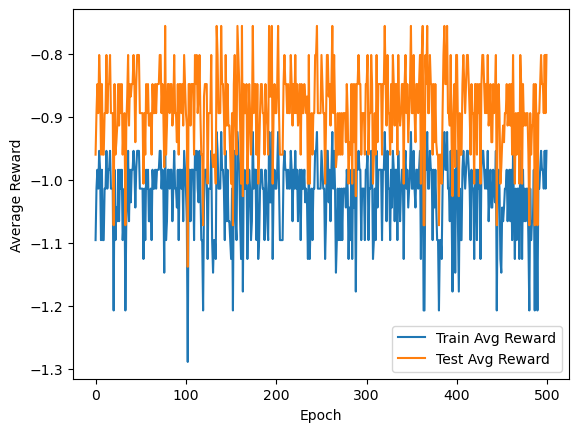

In [16]:
import numpy as np
import torch
import tqdm
from matplotlib import pyplot as plt
from transformers import BertTokenizer, BertModel

def bert_encode(sentences, bert_model, tokenizer, device, batch_size=32):
    bert_model.to(device)
    bert_model.eval()  # Modeli değerlendirme modunda çalıştır

    # Tüm cümleleri batch'ler halinde işle
    all_sentence_embeddings = []
    for i in tqdm.tqdm(range(0, len(sentences), batch_size), desc="BERT Encoding"):
        batch_sentences = sentences[i:i+batch_size]
        encoded = tokenizer.batch_encode_plus(
            batch_sentences,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            sentence_embeddings = outputs[0][:, 0, :]  # [CLS] token'ın çıktısını al
            all_sentence_embeddings.extend(sentence_embeddings.cpu().numpy())

    return np.array(all_sentence_embeddings)

def evaluate_performance(model, data_with_bert, device):
    total_reward = 0
    total_features = 0

    for data_point, encoded_sentences in data_with_bert:
        # Eğer encoded_sentences boyutu data_point['features'] boyutundan küçükse, son elemanı kopyala
        if len(encoded_sentences) < len(data_point['features']):
            last_embedding = encoded_sentences[-1]
            # Eksik boyut kadar son elemanın kopyasını ekle
            for _ in range(len(data_point['features']) - len(encoded_sentences)):
                encoded_sentences = np.append(encoded_sentences, [last_embedding], axis=0)

        for state_index, feature in enumerate(data_point['features']):
            state = np.concatenate((feature, encoded_sentences[state_index]))
            state_tensor = torch.tensor([state], dtype=torch.float32).to(device)
            with torch.no_grad():
                q_values = model.model(state_tensor)
            _, action = torch.max(q_values, 1)
            reward = data_point['slider_values'][action.item()]
            total_reward += reward
            total_features += 1

    return total_reward / total_features



def visualize_performance(performance_history):
    train_rewards, test_rewards = zip(*performance_history)
    plt.plot(train_rewards, label="Train Avg Reward")
    plt.plot(test_rewards, label="Test Avg Reward")
    plt.xlabel("Epoch")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.show()

def train_model(model, train_data_with_bert, test_data_with_bert, epochs, optimizer, criterion):
    performance_history = []
    early_stopping = EarlyStopping(patience=10, delta=0)
    try:
        for epoch in tqdm.tqdm(range(epochs), desc="Training", leave=False):
            for data_point, encoded_sentences in train_data_with_bert:
                # Tüm cümlelerin ortalamasını alarak tek bir temsilci vektör oluştur

                sentence_representation = np.mean(encoded_sentences, axis=0)
                for state_index, feature in enumerate(data_point['features']):
                    # Her bir feature ile tüm cümlelerin temsili birleştiriliyor
                    state = np.concatenate((feature, sentence_representation))
                    action = model.choose_action(state)
                    reward = data_point['slider_values'][action]
                    next_state_index = (state_index + 1) % len(data_point['features'])
                    next_state = np.concatenate((data_point['features'][next_state_index], sentence_representation))
                    model.update(state, action, reward, next_state)

            model.decay_exploration_rate()
            train_avg_reward = evaluate_performance(model, train_data_with_bert, model.device)
            test_avg_reward = evaluate_performance(model, test_data_with_bert, model.device)
            performance_history.append((train_avg_reward, test_avg_reward))
            print(f"Epoch {epoch}: Train Avg Reward = {train_avg_reward}, Test Avg Reward = {test_avg_reward}")

            if early_stopping(test_avg_reward):
                print("Early stopping")
                break
    except Exception as e:
        print(e)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        raise e

    return performance_history


state_size = len(train_data[0]['features'][0]) + 768
action_size = 3
learning_rate = 0.01
discount_factor = 0.9
exploration_rate = 0.5
use_gpu = True
epochs = 100

model = QLearningModel(state_size, action_size, learning_rate, discount_factor, exploration_rate, use_gpu)

optimizer = optim.RMSprop(model.model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

performance_history = train_model(model, train_data_with_bert, test_data_with_bert, epochs, optimizer, criterion)
visualize_performance(performance_history)

#### Visualize Sample And Get Rewards

In [52]:
import random

def display_predictions(model, data_with_bert, device):
    # Test veri setinden rastgele bir örnek seç
    data_point, encoded_sentences = random.choice(data_with_bert)
    sentence_representation = np.mean(encoded_sentences, axis=0)

    predicted_scores = []
    real_scores = data_point['slider_values']
    sentences = data_point['sentences']

    for state_index, feature in enumerate(data_point['features']):
        state = np.concatenate((feature, sentence_representation))
        state_tensor = torch.tensor([state], dtype=torch.float32).to(device)

        with torch.no_grad():
            q_values = model.model(state_tensor)
        _, action = torch.max(q_values, 1)
        predicted_score = action.item()

        predicted_scores.append(predicted_score)

    # Sonuçları göster
    print("Cümleler ve Tahmin Edilen / Gerçek Puanlar:\n")
    for i in range(len(sentences)):
        print(f"Cümle {i+1}: {sentences[i]}")
        print(f"Tahmin Edilen Puan: {predicted_scores[i]}, Gerçek Puan: {real_scores[i]}\n")

# Fonksiyonu kullanma
display_predictions(model, test_data_with_bert, model.device)

Cümleler ve Modelin Tahmin Ettiği Ödüller:
a blue roofed building has been constructed in the middle of the scene  - Tahmin Edilen Ödül: 0.00
the white roofed building has changed its color of the scene  - Tahmin Edilen Ödül: 0.00
The white roofed building has changed to the blue building in the middle of the scene  - Tahmin Edilen Ödül: 0.00

Cümleler ve Gerçek Ödüller:
a blue roofed building has been constructed in the middle of the scene  - Gerçek Ödül: -5.00
the white roofed building has changed its color of the scene  - Gerçek Ödül: -5.00
The white roofed building has changed to the blue building in the middle of the scene  - Gerçek Ödül: -5.00
